# Finetuning CNNs on medical image data

The objective of this homework is to use deep learning to recognize tumors in tissue image. We will use the [PCAM](https://github.com/basveeling/pcam) dataset consisting of "327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections".

**Note:** This homework will require intensive computations. It is thus preferable to use GPUs, for example with Google Colab (free access to GPUs).

In [7]:
!pip install --quiet torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time

!pip install --quiet --upgrade "git+https://gitlab.com/robindar/dl-scaman_checker.git"
from dl_scaman_checker import HW01
HW01.check_install(requires="0.7.1")

  Preparing metadata (setup.py) ... done
[DONE] Install ok. Version is v0.7.1


Version v0.7.1 or above of this module is required to bypass an error in torchvision's dataset download.
If the module version does not update when you re-run the previous cell, restart the Kernel of the notebook.
If you get an error on this cell, it is probably because the module did not update: restart your notebook Kernel and try again.

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Data preprocessing

First, download the PCAM dataset using torchvision (see [documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.PCAM.html#torchvision.datasets.PCAM)). To keep computation times low, we will use the validation set (parameter `split='val'`) as train set (variable name `data_train`), and the test set (parameter `split='test'`) as test (variable name `data_test`). Plot the first 5 images of the train set corresponding to a tumor and the 5 first corresponding to healthy tissue. Can you see a difference?

**Note:** If you get an error with the function provided by torchvision to download PCAM, please use `HW1.PCAM(...)` instead of `datasets.PCAM(...)`. This will download the dataset from another source, but will be slower (approx. 10 minutes).

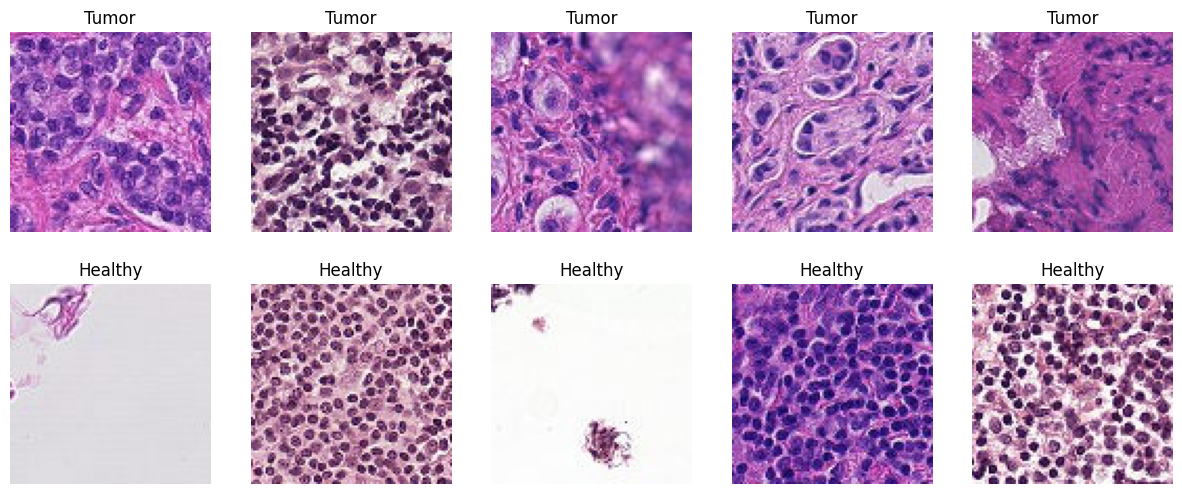

In [14]:
data_train = datasets.PCAM('./data', download=True, split='val', )
data_test = datasets.PCAM('./data', download=True, split='test')

# Get the first 5 images corresponding to a tumor and to healthy tissue
tumor_images = []
healthy_images = []

count_tumor = 0
count_healthy = 0

for img, label in data_train:
    if label == 1 and count_tumor < 5:
        tumor_images.append(transforms.ToTensor()(img))
        count_tumor += 1
    if label == 0 and count_healthy < 5:
        healthy_images.append(transforms.ToTensor()(img))
        count_healthy += 1
    if count_tumor == 5 and count_healthy == 5:
        break

# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, img in enumerate(tumor_images):
    axes[0, i].imshow(img.permute(1, 2, 0))
    axes[0, i].set_title('Tumor')
    axes[0, i].axis('off')

for i, img in enumerate(healthy_images):
    axes[1, i].imshow(img.permute(1, 2, 0))
    axes[1, i].set_title('Healthy')
    axes[1, i].axis('off')

plt.show()


Tumor tissue present a lot of irregularities compared to healthy tissue

Use `data_train.transform` and `data_test.transform` (see the [documentation](https://pytorch.org/vision/0.9/transforms.html)) to turn the images into tensors (of shape (3,96,96)) and normalize them using `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`, and verify that your data has the correct shape. How many elements are in your train and test sets?

In [15]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply the transformation to the datasets
data_train.transform = transform
data_test.transform = transform

# Verify the shape of the data
train_loader = torch.utils.data.DataLoader(data_train, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=1, shuffle=True)

# Get the first batch from the train and test loaders
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print(f'Train images shape: {train_images.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Number of elements in train set: {len(data_train)}')
print(f'Number of elements in test set: {len(data_test)}')

Train images shape: torch.Size([1, 3, 96, 96])
Test images shape: torch.Size([1, 3, 96, 96])
Number of elements in train set: 32768
Number of elements in test set: 32768


Now create a train and a test dataloader with a batch size of 64, and a random permutation for the train dataloader (with `shuffle=True`). How many mini-batches do you have?

In [16]:
# Create train and test dataloaders with batch size of 64
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=False)

# Calculate the number of mini-batches
num_train_batches = len(train_loader)
num_test_batches = len(test_loader)

print(f'Number of mini-batches in train set: {num_train_batches}')
print(f'Number of mini-batches in test set: {num_test_batches}')

# Create train and test dataloaders with batch size of 64
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=False)

# Calculate the number of mini-batches
num_train_batches = len(train_loader)
num_test_batches
print(f'Number of mini-batches in test set: {num_test_batches}')
print(f'Number of mini-batches in train set: {num_train_batches}')

train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=False)

# Calculate the number of mini-batches
num_train_batches = len(train_loader)
num_test_batches = len(test_loader)

Number of mini-batches in train set: 512
Number of mini-batches in test set: 512
Number of mini-batches in test set: 512
Number of mini-batches in train set: 512


## Training and testing loop

Write a function `train_model(model, dataloader, epochs)` that performs `epochs` training epochs using the Adam optimizer (with learning rate $10^{-3}$ and a weight decay of $10^{-1}$) on the cross entropy loss (using `nn.CrossEntropyLoss()`) for the model and data provided as input. **Note:** Remember to set the model to training mode using `model.train()`, and put the model and tensors on the correct device (CPU or GPU) by using `x.to(device)`. Plot the loss and accuracy of the model over the train set at each epoch.

In [17]:
def train_model(model, dataloader, epochs):
    # Set the model to training mode
    model.train()

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-1)

    # Lists to store loss and accuracy for each epoch
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in dataloader:
            # Move inputs and labels to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_accuracy = correct_predictions / total_predictions

        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Plot the loss and accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), epoch_losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), epoch_accuracies, label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.show()

Now write a function `test_model(model,dataloader)` that plots the loss and accuracy of the model on the whole dataset.

In [18]:
def test_model(model, dataloader):
    # Set the model to evaluation mode
    model.eval()

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            # Move inputs and labels to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update running loss
            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = correct_predictions / total_predictions

    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Plot the loss and accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(['Loss'], [avg_loss])
    plt.ylabel('Loss')
    plt.title('Test Loss')

    plt.subplot(1, 2, 2)
    plt.bar(['Accuracy'], [accuracy])
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')

    plt.show()

## Training a linear model

We now test a baseline model on our classification task: a simple linear model. Create a model using `nn.Sequential` that takes images, flatten them into vectors, and then compute a linear model out of it. The output should be 2-dimensional (to match our 2 classes). Then, train it for 2 epochs and test it on the test dataset.

Epoch 1/2, Loss: 2.0799, Accuracy: 0.5787
Epoch 2/2, Loss: 1.4582, Accuracy: 0.6271


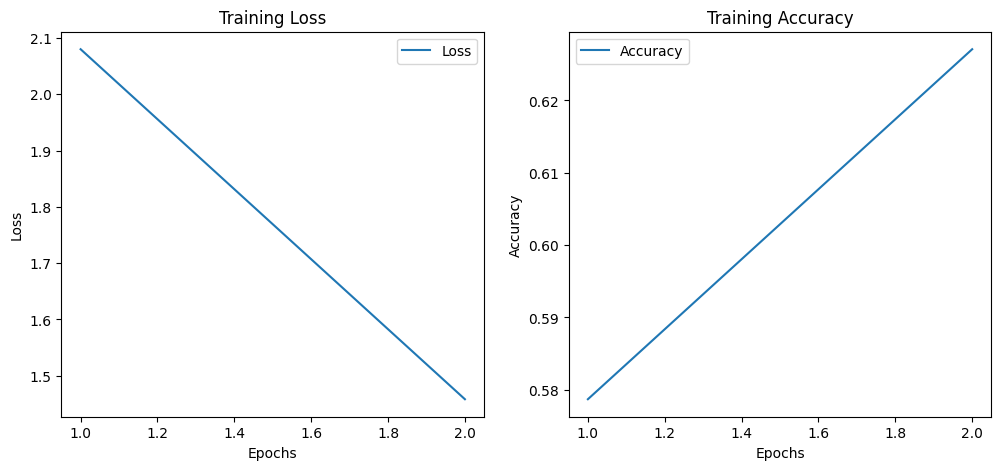

Loss: 2.3111, Accuracy: 0.5110


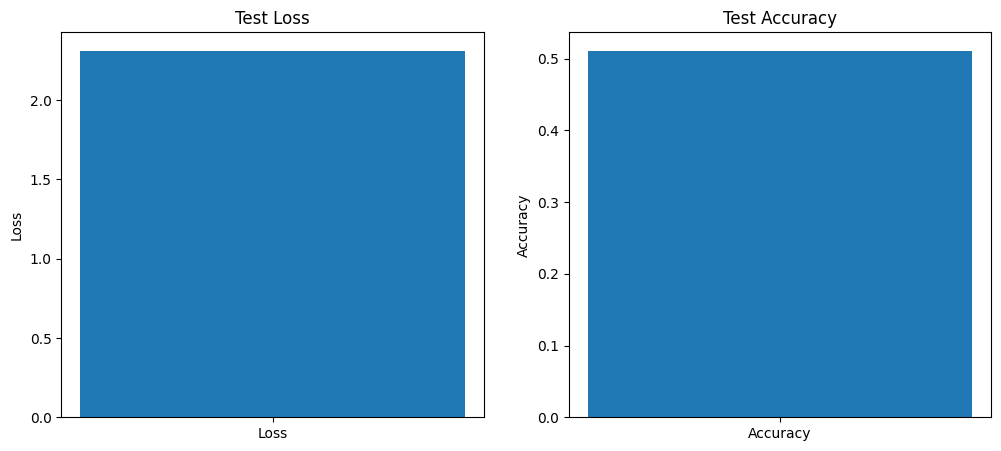

CPU times: user 2min 10s, sys: 21.2 s, total: 2min 31s
Wall time: 2min 33s


In [19]:
%%time

# Define the linear model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 96 * 96, 2)
)

# Move the model to the correct device
model.to(device)

# Train the model for 2 epochs
train_model(model, train_loader, epochs=2)

# Test the model on the test dataset
test_model(model, test_loader)

## Fine-tuning a CNN model

We are now going to fine-tune a VGG model trained on [ImageNet](http://www.image-net.org/) (1.2M training images). The torchvision module comes with a zoo of pretrained popular CNN architectures. When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`. For next calls, the model will be directly read from there.

First, load the VGG model using `models.vgg16(weights='DEFAULT')` and print it to see its architecture.

In [20]:
# Load the VGG model
vgg_model = models.vgg16(weights='DEFAULT')

# Print the architecture of the VGG model
print(vgg_model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Note that the model is divided into two part: a **feature** section mainly made of convolutions and pooling layers, and a **classifier** part made of an MLP. We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

The idea of fine-tuning is that the features computed by VGG for Imagenet may be also good for other applications (e.g. for medical images). Replace the last layer of the `model_vgg.classifier` by a new linear layer that outputs 2 values (one for each class), and **freeze** all the other parameters of the VGG model by using `parameter.requires_grad=False` on all the parameters of the model except for the last layer.

In [21]:
# Replace the last layer of the classifier
vgg_model.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# Freeze all the parameters except for the last layer
for param in vgg_model.parameters():
    param.requires_grad = False

for param in vgg_model.classifier[6].parameters():
    param.requires_grad = True

# Move the model to the correct device
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Now fine-tune the model by performing 2 epochs of training.

Epoch 1/2, Loss: 0.4762, Accuracy: 0.7715
Epoch 2/2, Loss: 0.4676, Accuracy: 0.7765


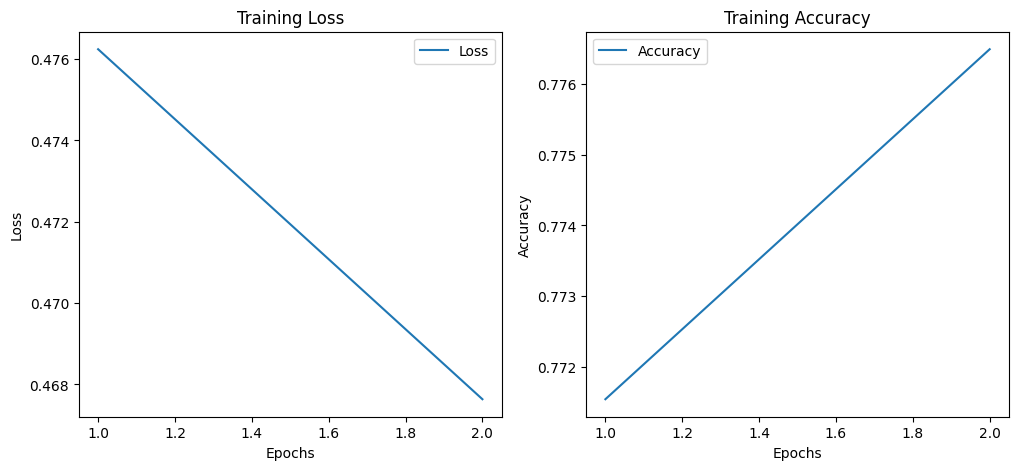

CPU times: user 2min 23s, sys: 14.2 s, total: 2min 37s
Wall time: 2min 38s


In [22]:
%%time
train_model(vgg_model, train_loader, epochs=2)

## Speeding-up training by precomputing features

We are wasting a lot of time computing over and over the same quantities. Indeed, the first part of the VGG model (called `features` and made of convolutional layers) is frozen and never updated. Hence, we can precompute for each image in the dataset, the output of these convolutional layers as these outputs will always be the same during your training process.

Write a function `precompute_model(model, dataloader)` that takes a model and a dataloader as input, and returns a dataset containing the outputs of the model as input using `torch.utils.data.TensorData`.

In [23]:
def precompute_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model.features(inputs)  # Extract features using the convolutional layers
            features.append(outputs.cpu())
            labels.append(targets.cpu())

    features = torch.cat(features)
    labels = torch.cat(labels)

    return torch.utils.data.TensorDataset(features, labels)

Use `precompute_model` to create a DataLoader for the train and test dataset with precomputed VGG features.

In [24]:
%%time
# Precompute features for the train and test datasets
train_features_dataset = precompute_model(vgg_model, train_loader)
test_features_dataset = precompute_model(vgg_model, test_loader)

# Create DataLoaders for the precomputed features
train_features_loader = torch.utils.data.DataLoader(train_features_dataset, batch_size=64, shuffle=True)
test_features_loader = torch.utils.data.DataLoader(test_features_dataset, batch_size=64, shuffle=False)

CPU times: user 2min 17s, sys: 13.8 s, total: 2min 31s
Wall time: 2min 32s


Finally, train a linear model on the new precomputed features for 10 epochs. Is the model better?

Epoch 1/10, Loss: 0.3545, Accuracy: 0.8434
Epoch 2/10, Loss: 0.3212, Accuracy: 0.8607
Epoch 3/10, Loss: 0.3233, Accuracy: 0.8601
Epoch 4/10, Loss: 0.3222, Accuracy: 0.8604
Epoch 5/10, Loss: 0.3188, Accuracy: 0.8636
Epoch 6/10, Loss: 0.3188, Accuracy: 0.8640
Epoch 7/10, Loss: 0.3199, Accuracy: 0.8615
Epoch 8/10, Loss: 0.3300, Accuracy: 0.8574
Epoch 9/10, Loss: 0.3171, Accuracy: 0.8642
Epoch 10/10, Loss: 0.3198, Accuracy: 0.8637


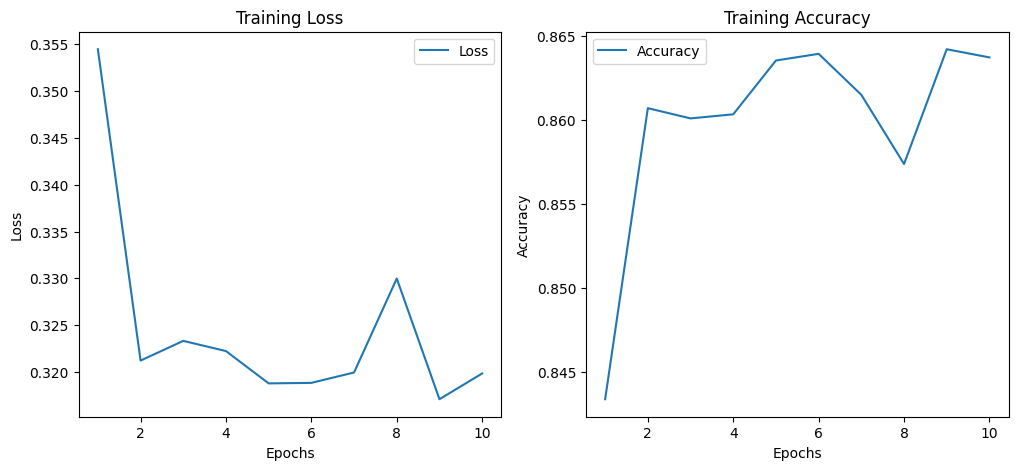

Loss: 0.6912, Accuracy: 0.7751


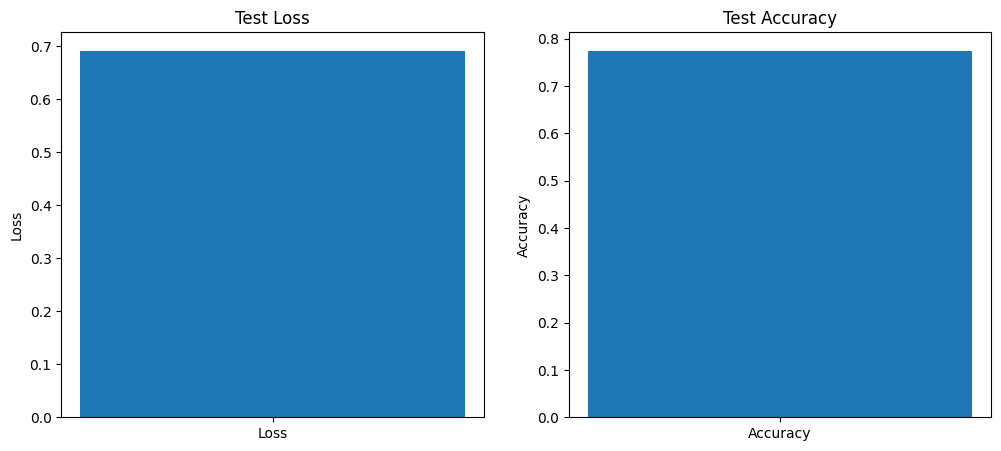

CPU times: user 12.8 s, sys: 372 ms, total: 13.2 s
Wall time: 13.9 s


In [27]:
%%time
# Define a new linear model for the precomputed features
linear_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(4608, 2)
)

# Move the model to the correct device
linear_model.to(device)

# Train the linear model for 10 epochs on the precomputed features
train_model(linear_model, train_features_loader, epochs=10)

# Test the linear model on the precomputed test features
test_model(linear_model, test_features_loader)

The accuracy and loss of this model are better.